In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:56 - loss: 1.5397 - STD: 0.1169 - MAE: 0.1794

 16/773 [..............................] - ETA: 2s - loss: 1.3539 - STD: 0.1923 - MAE: 0.1462   

 32/773 [>.............................] - ETA: 2s - loss: 1.3254 - STD: 0.1913 - MAE: 0.1455

 47/773 [>.............................] - ETA: 2s - loss: 1.3120 - STD: 0.1924 - MAE: 0.1445

 60/773 [=>............................] - ETA: 2s - loss: 1.2950 - STD: 0.1936 - MAE: 0.1434

 73/773 [=>............................] - ETA: 2s - loss: 1.2798 - STD: 0.1947 - MAE: 0.1425

 85/773 [==>...........................] - ETA: 2s - loss: 1.2680 - STD: 0.1952 - MAE: 0.1420

 98/773 [==>...........................] - ETA: 2s - loss: 1.2529 - STD: 0.1961 - MAE: 0.1412

111/773 [===>..........................] - ETA: 2s - loss: 1.2360 - STD: 0.1972 - MAE: 0.1402

124/773 [===>..........................] - ETA: 2s - loss: 1.2203 - STD: 0.1984 - MAE: 0.1392

138/773 [====>.........................] - ETA: 2s - loss: 1.2030 - STD: 0.1993 - MAE: 0.1383

152/773 [====>.........................] - ETA: 2s - loss: 1.1857 - STD: 0.2006 - MAE: 0.1372

167/773 [=====>........................] - ETA: 2s - loss: 1.1678 - STD: 0.2019 - MAE: 0.1361

183/773 [======>.......................] - ETA: 2s - loss: 1.1491 - STD: 0.2034 - MAE: 0.1348

198/773 [======>.......................] - ETA: 2s - loss: 1.1336 - STD: 0.2046 - MAE: 0.1338

211/773 [=======>......................] - ETA: 2s - loss: 1.1218 - STD: 0.2056 - MAE: 0.1329

225/773 [=======>......................] - ETA: 2s - loss: 1.1090 - STD: 0.2069 - MAE: 0.1319

240/773 [========>.....................] - ETA: 1s - loss: 1.0968 - STD: 0.2079 - MAE: 0.1310

254/773 [========>.....................] - ETA: 1s - loss: 1.0859 - STD: 0.2089 - MAE: 0.1302

270/773 [=========>....................] - ETA: 1s - loss: 1.0760 - STD: 0.2098 - MAE: 0.1294

283/773 [=========>....................] - ETA: 1s - loss: 1.0679 - STD: 0.2106 - MAE: 0.1287

296/773 [==========>...................] - ETA: 1s - loss: 1.0616 - STD: 0.2112 - MAE: 0.1283

309/773 [==========>...................] - ETA: 1s - loss: 1.0553 - STD: 0.2118 - MAE: 0.1278

323/773 [===========>..................] - ETA: 1s - loss: 1.0480 - STD: 0.2125 - MAE: 0.1272

337/773 [============>.................] - ETA: 1s - loss: 1.0422 - STD: 0.2131 - MAE: 0.1267

354/773 [============>.................] - ETA: 1s - loss: 1.0353 - STD: 0.2138 - MAE: 0.1261

372/773 [=============>................] - ETA: 1s - loss: 1.0281 - STD: 0.2145 - MAE: 0.1256

374/773 [=============>................] - ETA: 2s - loss: 1.0276 - STD: 0.2146 - MAE: 0.1255

391/773 [==============>...............] - ETA: 1s - loss: 1.0219 - STD: 0.2151 - MAE: 0.1251

408/773 [==============>...............] - ETA: 1s - loss: 1.0162 - STD: 0.2157 - MAE: 0.1246

425/773 [===============>..............] - ETA: 1s - loss: 1.0103 - STD: 0.2162 - MAE: 0.1241

442/773 [================>.............] - ETA: 1s - loss: 1.0049 - STD: 0.2168 - MAE: 0.1237

457/773 [================>.............] - ETA: 1s - loss: 1.0007 - STD: 0.2171 - MAE: 0.1233

473/773 [=================>............] - ETA: 1s - loss: 0.9965 - STD: 0.2175 - MAE: 0.1230

485/773 [=================>............] - ETA: 1s - loss: 0.9932 - STD: 0.2179 - MAE: 0.1227

498/773 [==================>...........] - ETA: 1s - loss: 0.9896 - STD: 0.2182 - MAE: 0.1224

510/773 [==================>...........] - ETA: 1s - loss: 0.9866 - STD: 0.2185 - MAE: 0.1222

522/773 [===================>..........] - ETA: 1s - loss: 0.9837 - STD: 0.2188 - MAE: 0.1219

536/773 [===================>..........] - ETA: 1s - loss: 0.9805 - STD: 0.2191 - MAE: 0.1217

550/773 [====================>.........] - ETA: 1s - loss: 0.9776 - STD: 0.2194 - MAE: 0.1214

563/773 [====================>.........] - ETA: 0s - loss: 0.9746 - STD: 0.2197 - MAE: 0.1212

576/773 [=====================>........] - ETA: 0s - loss: 0.9718 - STD: 0.2200 - MAE: 0.1209

588/773 [=====================>........] - ETA: 0s - loss: 0.9692 - STD: 0.2202 - MAE: 0.1207

601/773 [======================>.......] - ETA: 0s - loss: 0.9667 - STD: 0.2205 - MAE: 0.1205

615/773 [======================>.......] - ETA: 0s - loss: 0.9640 - STD: 0.2207 - MAE: 0.1203

627/773 [=======================>......] - ETA: 0s - loss: 0.9614 - STD: 0.2210 - MAE: 0.1200

639/773 [=======================>......] - ETA: 0s - loss: 0.9591 - STD: 0.2212 - MAE: 0.1198

652/773 [========================>.....] - ETA: 0s - loss: 0.9567 - STD: 0.2215 - MAE: 0.1196

665/773 [========================>.....] - ETA: 0s - loss: 0.9545 - STD: 0.2217 - MAE: 0.1194

678/773 [=========================>....] - ETA: 0s - loss: 0.9524 - STD: 0.2220 - MAE: 0.1192

692/773 [=========================>....] - ETA: 0s - loss: 0.9502 - STD: 0.2222 - MAE: 0.1191

707/773 [==========================>...] - ETA: 0s - loss: 0.9478 - STD: 0.2224 - MAE: 0.1188

724/773 [===========================>..] - ETA: 0s - loss: 0.9447 - STD: 0.2227 - MAE: 0.1186

737/773 [===========================>..] - ETA: 0s - loss: 0.9428 - STD: 0.2229 - MAE: 0.1184

751/773 [============================>.] - ETA: 0s - loss: 0.9405 - STD: 0.2232 - MAE: 0.1182

768/773 [============================>.] - ETA: 0s - loss: 0.9379 - STD: 0.2235 - MAE: 0.1179

773/773 [==============================] - 5s 5ms/step - loss: 0.9372 - STD: 0.2235 - MAE: 0.1179 - val_loss: 0.8464 - val_STD: 0.2244 - val_MAE: 0.1113


Epoch 2/10000


  1/773 [..............................] - ETA: 18s - loss: 0.8226 - STD: 0.2281 - MAE: 0.1105

 18/773 [..............................] - ETA: 2s - loss: 0.8192 - STD: 0.2351 - MAE: 0.1075 

 35/773 [>.............................] - ETA: 2s - loss: 0.8198 - STD: 0.2354 - MAE: 0.1074

 53/773 [=>............................] - ETA: 2s - loss: 0.8246 - STD: 0.2351 - MAE: 0.1079

 68/773 [=>............................] - ETA: 2s - loss: 0.8271 - STD: 0.2348 - MAE: 0.1082

 82/773 [==>...........................] - ETA: 2s - loss: 0.8251 - STD: 0.2349 - MAE: 0.1081

 95/773 [==>...........................] - ETA: 2s - loss: 0.8245 - STD: 0.2350 - MAE: 0.1080

108/773 [===>..........................] - ETA: 2s - loss: 0.8227 - STD: 0.2350 - MAE: 0.1079

120/773 [===>..........................] - ETA: 2s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1076

133/773 [====>.........................] - ETA: 2s - loss: 0.8188 - STD: 0.2354 - MAE: 0.1076

147/773 [====>.........................] - ETA: 2s - loss: 0.8176 - STD: 0.2355 - MAE: 0.1075

162/773 [=====>........................] - ETA: 2s - loss: 0.8180 - STD: 0.2356 - MAE: 0.1075

178/773 [=====>........................] - ETA: 2s - loss: 0.8161 - STD: 0.2357 - MAE: 0.1073

192/773 [======>.......................] - ETA: 2s - loss: 0.8169 - STD: 0.2357 - MAE: 0.1074

208/773 [=======>......................] - ETA: 1s - loss: 0.8156 - STD: 0.2357 - MAE: 0.1073

224/773 [=======>......................] - ETA: 1s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1072

237/773 [========>.....................] - ETA: 1s - loss: 0.8146 - STD: 0.2359 - MAE: 0.1072

250/773 [========>.....................] - ETA: 1s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1071

264/773 [=========>....................] - ETA: 1s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1070

278/773 [=========>....................] - ETA: 1s - loss: 0.8123 - STD: 0.2360 - MAE: 0.1070

292/773 [==========>...................] - ETA: 1s - loss: 0.8119 - STD: 0.2359 - MAE: 0.1071

305/773 [==========>...................] - ETA: 1s - loss: 0.8108 - STD: 0.2361 - MAE: 0.1070

318/773 [===========>..................] - ETA: 1s - loss: 0.8109 - STD: 0.2362 - MAE: 0.1069

332/773 [===========>..................] - ETA: 1s - loss: 0.8109 - STD: 0.2361 - MAE: 0.1069

347/773 [============>.................] - ETA: 1s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1068

360/773 [============>.................] - ETA: 1s - loss: 0.8090 - STD: 0.2363 - MAE: 0.1068

372/773 [=============>................] - ETA: 1s - loss: 0.8080 - STD: 0.2363 - MAE: 0.1067

385/773 [=============>................] - ETA: 1s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1066

399/773 [==============>...............] - ETA: 1s - loss: 0.8061 - STD: 0.2366 - MAE: 0.1065

412/773 [==============>...............] - ETA: 1s - loss: 0.8054 - STD: 0.2367 - MAE: 0.1064

426/773 [===============>..............] - ETA: 1s - loss: 0.8046 - STD: 0.2368 - MAE: 0.1063

439/773 [================>.............] - ETA: 1s - loss: 0.8045 - STD: 0.2368 - MAE: 0.1063

451/773 [================>.............] - ETA: 1s - loss: 0.8040 - STD: 0.2369 - MAE: 0.1062

464/773 [=================>............] - ETA: 1s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1062

476/773 [=================>............] - ETA: 1s - loss: 0.8029 - STD: 0.2370 - MAE: 0.1061

489/773 [=================>............] - ETA: 1s - loss: 0.8029 - STD: 0.2370 - MAE: 0.1061

501/773 [==================>...........] - ETA: 1s - loss: 0.8021 - STD: 0.2371 - MAE: 0.1061

513/773 [==================>...........] - ETA: 0s - loss: 0.8012 - STD: 0.2371 - MAE: 0.1060

528/773 [===================>..........] - ETA: 0s - loss: 0.8001 - STD: 0.2372 - MAE: 0.1059

540/773 [===================>..........] - ETA: 0s - loss: 0.7995 - STD: 0.2373 - MAE: 0.1058

553/773 [====================>.........] - ETA: 0s - loss: 0.7984 - STD: 0.2374 - MAE: 0.1057

569/773 [=====================>........] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1056

583/773 [=====================>........] - ETA: 0s - loss: 0.7969 - STD: 0.2376 - MAE: 0.1056

595/773 [======================>.......] - ETA: 0s - loss: 0.7963 - STD: 0.2376 - MAE: 0.1055

610/773 [======================>.......] - ETA: 0s - loss: 0.7955 - STD: 0.2377 - MAE: 0.1054

626/773 [=======================>......] - ETA: 0s - loss: 0.7946 - STD: 0.2378 - MAE: 0.1053

642/773 [=======================>......] - ETA: 0s - loss: 0.7943 - STD: 0.2379 - MAE: 0.1053

657/773 [========================>.....] - ETA: 0s - loss: 0.7936 - STD: 0.2380 - MAE: 0.1052

673/773 [=========================>....] - ETA: 0s - loss: 0.7931 - STD: 0.2380 - MAE: 0.1051

689/773 [=========================>....] - ETA: 0s - loss: 0.7926 - STD: 0.2381 - MAE: 0.1051

706/773 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2382 - MAE: 0.1050

722/773 [===========================>..] - ETA: 0s - loss: 0.7909 - STD: 0.2382 - MAE: 0.1049

738/773 [===========================>..] - ETA: 0s - loss: 0.7899 - STD: 0.2383 - MAE: 0.1048

754/773 [============================>.] - ETA: 0s - loss: 0.7895 - STD: 0.2384 - MAE: 0.1048

771/773 [============================>.] - ETA: 0s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1048

773/773 [==============================] - 3s 4ms/step - loss: 0.7891 - STD: 0.2384 - MAE: 0.1048 - val_loss: 0.7840 - val_STD: 0.2490 - val_MAE: 0.0974


Epoch 3/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7294 - STD: 0.2502 - MAE: 0.0959

 17/773 [..............................] - ETA: 2s - loss: 0.7771 - STD: 0.2411 - MAE: 0.1034 

 35/773 [>.............................] - ETA: 2s - loss: 0.7695 - STD: 0.2400 - MAE: 0.1034

 52/773 [=>............................] - ETA: 2s - loss: 0.7644 - STD: 0.2406 - MAE: 0.1028

 69/773 [=>............................] - ETA: 2s - loss: 0.7604 - STD: 0.2413 - MAE: 0.1021

 86/773 [==>...........................] - ETA: 2s - loss: 0.7605 - STD: 0.2413 - MAE: 0.1021

101/773 [==>...........................] - ETA: 2s - loss: 0.7592 - STD: 0.2413 - MAE: 0.1020

115/773 [===>..........................] - ETA: 2s - loss: 0.7581 - STD: 0.2415 - MAE: 0.1019

128/773 [===>..........................] - ETA: 2s - loss: 0.7566 - STD: 0.2416 - MAE: 0.1018

141/773 [====>.........................] - ETA: 2s - loss: 0.7561 - STD: 0.2415 - MAE: 0.1018

156/773 [=====>........................] - ETA: 2s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1018

172/773 [=====>........................] - ETA: 2s - loss: 0.7560 - STD: 0.2417 - MAE: 0.1017

185/773 [======>.......................] - ETA: 1s - loss: 0.7560 - STD: 0.2417 - MAE: 0.1017

198/773 [======>.......................] - ETA: 1s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1017

210/773 [=======>......................] - ETA: 1s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1017

223/773 [=======>......................] - ETA: 1s - loss: 0.7540 - STD: 0.2417 - MAE: 0.1016

237/773 [========>.....................] - ETA: 1s - loss: 0.7530 - STD: 0.2419 - MAE: 0.1015

251/773 [========>.....................] - ETA: 1s - loss: 0.7523 - STD: 0.2419 - MAE: 0.1015

264/773 [=========>....................] - ETA: 1s - loss: 0.7522 - STD: 0.2419 - MAE: 0.1014

279/773 [=========>....................] - ETA: 1s - loss: 0.7524 - STD: 0.2420 - MAE: 0.1014

296/773 [==========>...................] - ETA: 1s - loss: 0.7529 - STD: 0.2420 - MAE: 0.1014

314/773 [===========>..................] - ETA: 1s - loss: 0.7526 - STD: 0.2420 - MAE: 0.1014

331/773 [===========>..................] - ETA: 1s - loss: 0.7522 - STD: 0.2420 - MAE: 0.1014

348/773 [============>.................] - ETA: 1s - loss: 0.7519 - STD: 0.2420 - MAE: 0.1014

365/773 [=============>................] - ETA: 1s - loss: 0.7511 - STD: 0.2421 - MAE: 0.1013

382/773 [=============>................] - ETA: 1s - loss: 0.7504 - STD: 0.2422 - MAE: 0.1012

398/773 [==============>...............] - ETA: 1s - loss: 0.7506 - STD: 0.2422 - MAE: 0.1012

414/773 [===============>..............] - ETA: 1s - loss: 0.7521 - STD: 0.2422 - MAE: 0.1013

430/773 [===============>..............] - ETA: 1s - loss: 0.7523 - STD: 0.2422 - MAE: 0.1013

445/773 [================>.............] - ETA: 1s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1012

461/773 [================>.............] - ETA: 1s - loss: 0.7521 - STD: 0.2422 - MAE: 0.1013

477/773 [=================>............] - ETA: 1s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1013

493/773 [==================>...........] - ETA: 0s - loss: 0.7508 - STD: 0.2422 - MAE: 0.1012

509/773 [==================>...........] - ETA: 0s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1011

525/773 [===================>..........] - ETA: 0s - loss: 0.7497 - STD: 0.2423 - MAE: 0.1011

540/773 [===================>..........] - ETA: 0s - loss: 0.7490 - STD: 0.2424 - MAE: 0.1010

555/773 [====================>.........] - ETA: 0s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1010

570/773 [=====================>........] - ETA: 0s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1009

586/773 [=====================>........] - ETA: 0s - loss: 0.7483 - STD: 0.2425 - MAE: 0.1009

601/773 [======================>.......] - ETA: 0s - loss: 0.7479 - STD: 0.2426 - MAE: 0.1009

617/773 [======================>.......] - ETA: 0s - loss: 0.7475 - STD: 0.2427 - MAE: 0.1008

632/773 [=======================>......] - ETA: 0s - loss: 0.7469 - STD: 0.2427 - MAE: 0.1007

648/773 [========================>.....] - ETA: 0s - loss: 0.7462 - STD: 0.2428 - MAE: 0.1007

664/773 [========================>.....] - ETA: 0s - loss: 0.7458 - STD: 0.2428 - MAE: 0.1006

681/773 [=========================>....] - ETA: 0s - loss: 0.7451 - STD: 0.2429 - MAE: 0.1006

697/773 [==========================>...] - ETA: 0s - loss: 0.7446 - STD: 0.2429 - MAE: 0.1005

714/773 [==========================>...] - ETA: 0s - loss: 0.7442 - STD: 0.2429 - MAE: 0.1005

730/773 [===========================>..] - ETA: 0s - loss: 0.7443 - STD: 0.2430 - MAE: 0.1005

746/773 [===========================>..] - ETA: 0s - loss: 0.7439 - STD: 0.2430 - MAE: 0.1004

761/773 [============================>.] - ETA: 0s - loss: 0.7433 - STD: 0.2431 - MAE: 0.1004

773/773 [==============================] - 3s 4ms/step - loss: 0.7428 - STD: 0.2431 - MAE: 0.1003 - val_loss: 0.7779 - val_STD: 0.2395 - val_MAE: 0.1017


Epoch 4/10000


  1/773 [..............................] - ETA: 14s - loss: 0.7256 - STD: 0.2410 - MAE: 0.1023

 15/773 [..............................] - ETA: 2s - loss: 0.7230 - STD: 0.2453 - MAE: 0.0984 

 30/773 [>.............................] - ETA: 2s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0986

 43/773 [>.............................] - ETA: 2s - loss: 0.7268 - STD: 0.2450 - MAE: 0.0987

 55/773 [=>............................] - ETA: 2s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0984

 67/773 [=>............................] - ETA: 2s - loss: 0.7210 - STD: 0.2456 - MAE: 0.0980

 79/773 [==>...........................] - ETA: 2s - loss: 0.7224 - STD: 0.2452 - MAE: 0.0983

 91/773 [==>...........................] - ETA: 2s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0985

104/773 [===>..........................] - ETA: 2s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0985

117/773 [===>..........................] - ETA: 2s - loss: 0.7234 - STD: 0.2451 - MAE: 0.0984

132/773 [====>.........................] - ETA: 2s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

147/773 [====>.........................] - ETA: 2s - loss: 0.7270 - STD: 0.2451 - MAE: 0.0986

161/773 [=====>........................] - ETA: 2s - loss: 0.7283 - STD: 0.2450 - MAE: 0.0987

175/773 [=====>........................] - ETA: 2s - loss: 0.7277 - STD: 0.2450 - MAE: 0.0987

188/773 [======>.......................] - ETA: 2s - loss: 0.7273 - STD: 0.2450 - MAE: 0.0986

201/773 [======>.......................] - ETA: 2s - loss: 0.7272 - STD: 0.2449 - MAE: 0.0986

213/773 [=======>......................] - ETA: 2s - loss: 0.7271 - STD: 0.2449 - MAE: 0.0986

226/773 [=======>......................] - ETA: 2s - loss: 0.7272 - STD: 0.2450 - MAE: 0.0986

242/773 [========>.....................] - ETA: 2s - loss: 0.7265 - STD: 0.2450 - MAE: 0.0986

258/773 [=========>....................] - ETA: 1s - loss: 0.7260 - STD: 0.2451 - MAE: 0.0985

275/773 [=========>....................] - ETA: 1s - loss: 0.7264 - STD: 0.2449 - MAE: 0.0986

292/773 [==========>...................] - ETA: 1s - loss: 0.7264 - STD: 0.2450 - MAE: 0.0986

309/773 [==========>...................] - ETA: 1s - loss: 0.7267 - STD: 0.2450 - MAE: 0.0987

324/773 [===========>..................] - ETA: 1s - loss: 0.7267 - STD: 0.2450 - MAE: 0.0986

340/773 [============>.................] - ETA: 1s - loss: 0.7266 - STD: 0.2450 - MAE: 0.0986

356/773 [============>.................] - ETA: 1s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0986

373/773 [=============>................] - ETA: 1s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0986

389/773 [==============>...............] - ETA: 1s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0985

406/773 [==============>...............] - ETA: 1s - loss: 0.7242 - STD: 0.2451 - MAE: 0.0984

423/773 [===============>..............] - ETA: 1s - loss: 0.7236 - STD: 0.2452 - MAE: 0.0983

441/773 [================>.............] - ETA: 1s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0983

459/773 [================>.............] - ETA: 1s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0982

477/773 [=================>............] - ETA: 1s - loss: 0.7218 - STD: 0.2454 - MAE: 0.0982

494/773 [==================>...........] - ETA: 0s - loss: 0.7209 - STD: 0.2454 - MAE: 0.0981

511/773 [==================>...........] - ETA: 0s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0980

528/773 [===================>..........] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0980

544/773 [====================>.........] - ETA: 0s - loss: 0.7193 - STD: 0.2456 - MAE: 0.0979

560/773 [====================>.........] - ETA: 0s - loss: 0.7190 - STD: 0.2456 - MAE: 0.0979

577/773 [=====================>........] - ETA: 0s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0979

594/773 [======================>.......] - ETA: 0s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0979

609/773 [======================>.......] - ETA: 0s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0979

626/773 [=======================>......] - ETA: 0s - loss: 0.7177 - STD: 0.2457 - MAE: 0.0978

644/773 [=======================>......] - ETA: 0s - loss: 0.7174 - STD: 0.2457 - MAE: 0.0978

662/773 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2458 - MAE: 0.0977

678/773 [=========================>....] - ETA: 0s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0977

694/773 [=========================>....] - ETA: 0s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0977

710/773 [==========================>...] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0977

726/773 [===========================>..] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0977

742/773 [===========================>..] - ETA: 0s - loss: 0.7163 - STD: 0.2459 - MAE: 0.0977

758/773 [============================>.] - ETA: 0s - loss: 0.7157 - STD: 0.2459 - MAE: 0.0976

773/773 [==============================] - 3s 4ms/step - loss: 0.7152 - STD: 0.2459 - MAE: 0.0976 - val_loss: 0.7242 - val_STD: 0.2423 - val_MAE: 0.0984


Epoch 5/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6966 - STD: 0.2418 - MAE: 0.0992

 15/773 [..............................] - ETA: 2s - loss: 0.6968 - STD: 0.2475 - MAE: 0.0959 

 28/773 [>.............................] - ETA: 2s - loss: 0.6976 - STD: 0.2477 - MAE: 0.0959

 42/773 [>.............................] - ETA: 2s - loss: 0.7057 - STD: 0.2471 - MAE: 0.0966

 55/773 [=>............................] - ETA: 2s - loss: 0.7126 - STD: 0.2468 - MAE: 0.0971

 67/773 [=>............................] - ETA: 2s - loss: 0.7098 - STD: 0.2470 - MAE: 0.0969

 79/773 [==>...........................] - ETA: 2s - loss: 0.7088 - STD: 0.2468 - MAE: 0.0969

 91/773 [==>...........................] - ETA: 2s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0969

106/773 [===>..........................] - ETA: 2s - loss: 0.7079 - STD: 0.2471 - MAE: 0.0967

123/773 [===>..........................] - ETA: 2s - loss: 0.7074 - STD: 0.2470 - MAE: 0.0968

140/773 [====>.........................] - ETA: 2s - loss: 0.7068 - STD: 0.2469 - MAE: 0.0968

157/773 [=====>........................] - ETA: 2s - loss: 0.7054 - STD: 0.2470 - MAE: 0.0967

173/773 [=====>........................] - ETA: 2s - loss: 0.7049 - STD: 0.2471 - MAE: 0.0966

189/773 [======>.......................] - ETA: 2s - loss: 0.7046 - STD: 0.2472 - MAE: 0.0965

205/773 [======>.......................] - ETA: 2s - loss: 0.7039 - STD: 0.2472 - MAE: 0.0964

221/773 [=======>......................] - ETA: 1s - loss: 0.7028 - STD: 0.2473 - MAE: 0.0963

237/773 [========>.....................] - ETA: 1s - loss: 0.7026 - STD: 0.2473 - MAE: 0.0963

253/773 [========>.....................] - ETA: 1s - loss: 0.7009 - STD: 0.2474 - MAE: 0.0961

270/773 [=========>....................] - ETA: 1s - loss: 0.7003 - STD: 0.2475 - MAE: 0.0961

287/773 [==========>...................] - ETA: 1s - loss: 0.7004 - STD: 0.2475 - MAE: 0.0961

303/773 [==========>...................] - ETA: 1s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0960

320/773 [===========>..................] - ETA: 1s - loss: 0.6991 - STD: 0.2475 - MAE: 0.0960

337/773 [============>.................] - ETA: 1s - loss: 0.6987 - STD: 0.2476 - MAE: 0.0959

353/773 [============>.................] - ETA: 1s - loss: 0.6983 - STD: 0.2477 - MAE: 0.0959

369/773 [=============>................] - ETA: 1s - loss: 0.6985 - STD: 0.2476 - MAE: 0.0959

386/773 [=============>................] - ETA: 1s - loss: 0.6982 - STD: 0.2477 - MAE: 0.0959

404/773 [==============>...............] - ETA: 1s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0958

422/773 [===============>..............] - ETA: 1s - loss: 0.6980 - STD: 0.2477 - MAE: 0.0958

439/773 [================>.............] - ETA: 1s - loss: 0.6980 - STD: 0.2478 - MAE: 0.0958

455/773 [================>.............] - ETA: 1s - loss: 0.6977 - STD: 0.2478 - MAE: 0.0958

472/773 [=================>............] - ETA: 0s - loss: 0.6968 - STD: 0.2479 - MAE: 0.0957

489/773 [=================>............] - ETA: 0s - loss: 0.6968 - STD: 0.2478 - MAE: 0.0957

506/773 [==================>...........] - ETA: 0s - loss: 0.6970 - STD: 0.2479 - MAE: 0.0957

523/773 [===================>..........] - ETA: 0s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0958

540/773 [===================>..........] - ETA: 0s - loss: 0.6972 - STD: 0.2478 - MAE: 0.0957

557/773 [====================>.........] - ETA: 0s - loss: 0.6969 - STD: 0.2478 - MAE: 0.0957

573/773 [=====================>........] - ETA: 0s - loss: 0.6966 - STD: 0.2479 - MAE: 0.0957

589/773 [=====================>........] - ETA: 0s - loss: 0.6968 - STD: 0.2479 - MAE: 0.0957

605/773 [======================>.......] - ETA: 0s - loss: 0.6964 - STD: 0.2479 - MAE: 0.0957

622/773 [=======================>......] - ETA: 0s - loss: 0.6963 - STD: 0.2479 - MAE: 0.0956

638/773 [=======================>......] - ETA: 0s - loss: 0.6960 - STD: 0.2479 - MAE: 0.0956

653/773 [========================>.....] - ETA: 0s - loss: 0.6962 - STD: 0.2480 - MAE: 0.0956

669/773 [========================>.....] - ETA: 0s - loss: 0.6960 - STD: 0.2480 - MAE: 0.0956

686/773 [=========================>....] - ETA: 0s - loss: 0.6957 - STD: 0.2480 - MAE: 0.0956

703/773 [==========================>...] - ETA: 0s - loss: 0.6956 - STD: 0.2480 - MAE: 0.0956

720/773 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2480 - MAE: 0.0955

737/773 [===========================>..] - ETA: 0s - loss: 0.6952 - STD: 0.2481 - MAE: 0.0955

754/773 [============================>.] - ETA: 0s - loss: 0.6950 - STD: 0.2481 - MAE: 0.0955

770/773 [============================>.] - ETA: 0s - loss: 0.6947 - STD: 0.2481 - MAE: 0.0955

773/773 [==============================] - 3s 4ms/step - loss: 0.6946 - STD: 0.2481 - MAE: 0.0955 - val_loss: 0.7351 - val_STD: 0.2431 - val_MAE: 0.0984


Epoch 6/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6371 - STD: 0.2495 - MAE: 0.0915

 18/773 [..............................] - ETA: 2s - loss: 0.6876 - STD: 0.2499 - MAE: 0.0942 

 34/773 [>.............................] - ETA: 2s - loss: 0.6977 - STD: 0.2479 - MAE: 0.0959

 52/773 [=>............................] - ETA: 2s - loss: 0.6923 - STD: 0.2487 - MAE: 0.0950

 69/773 [=>............................] - ETA: 2s - loss: 0.6894 - STD: 0.2488 - MAE: 0.0948

 86/773 [==>...........................] - ETA: 2s - loss: 0.6888 - STD: 0.2489 - MAE: 0.0947

104/773 [===>..........................] - ETA: 2s - loss: 0.6888 - STD: 0.2487 - MAE: 0.0948

121/773 [===>..........................] - ETA: 1s - loss: 0.6876 - STD: 0.2488 - MAE: 0.0947

138/773 [====>.........................] - ETA: 1s - loss: 0.6854 - STD: 0.2490 - MAE: 0.0945

154/773 [====>.........................] - ETA: 1s - loss: 0.6837 - STD: 0.2491 - MAE: 0.0944

170/773 [=====>........................] - ETA: 1s - loss: 0.6837 - STD: 0.2493 - MAE: 0.0943

186/773 [======>.......................] - ETA: 1s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0944

202/773 [======>.......................] - ETA: 1s - loss: 0.6841 - STD: 0.2492 - MAE: 0.0944

218/773 [=======>......................] - ETA: 1s - loss: 0.6847 - STD: 0.2490 - MAE: 0.0945

234/773 [========>.....................] - ETA: 1s - loss: 0.6851 - STD: 0.2491 - MAE: 0.0945

249/773 [========>.....................] - ETA: 1s - loss: 0.6848 - STD: 0.2490 - MAE: 0.0945

266/773 [=========>....................] - ETA: 1s - loss: 0.6840 - STD: 0.2491 - MAE: 0.0944

282/773 [=========>....................] - ETA: 1s - loss: 0.6832 - STD: 0.2492 - MAE: 0.0943

298/773 [==========>...................] - ETA: 1s - loss: 0.6824 - STD: 0.2493 - MAE: 0.0942

314/773 [===========>..................] - ETA: 1s - loss: 0.6815 - STD: 0.2494 - MAE: 0.0941

330/773 [===========>..................] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0940

342/773 [============>.................] - ETA: 1s - loss: 0.6814 - STD: 0.2495 - MAE: 0.0940

354/773 [============>.................] - ETA: 1s - loss: 0.6817 - STD: 0.2494 - MAE: 0.0941

370/773 [=============>................] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0940

386/773 [=============>................] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0940

402/773 [==============>...............] - ETA: 1s - loss: 0.6814 - STD: 0.2495 - MAE: 0.0940

418/773 [===============>..............] - ETA: 1s - loss: 0.6819 - STD: 0.2495 - MAE: 0.0941

433/773 [===============>..............] - ETA: 1s - loss: 0.6821 - STD: 0.2495 - MAE: 0.0941

448/773 [================>.............] - ETA: 1s - loss: 0.6820 - STD: 0.2495 - MAE: 0.0941

461/773 [================>.............] - ETA: 1s - loss: 0.6814 - STD: 0.2495 - MAE: 0.0941

476/773 [=================>............] - ETA: 0s - loss: 0.6813 - STD: 0.2495 - MAE: 0.0940

490/773 [==================>...........] - ETA: 0s - loss: 0.6815 - STD: 0.2496 - MAE: 0.0940

502/773 [==================>...........] - ETA: 0s - loss: 0.6816 - STD: 0.2495 - MAE: 0.0941

517/773 [===================>..........] - ETA: 0s - loss: 0.6814 - STD: 0.2496 - MAE: 0.0940

534/773 [===================>..........] - ETA: 0s - loss: 0.6810 - STD: 0.2496 - MAE: 0.0940

551/773 [====================>.........] - ETA: 0s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0940

567/773 [=====================>........] - ETA: 0s - loss: 0.6807 - STD: 0.2496 - MAE: 0.0940

582/773 [=====================>........] - ETA: 0s - loss: 0.6803 - STD: 0.2496 - MAE: 0.0940

598/773 [======================>.......] - ETA: 0s - loss: 0.6799 - STD: 0.2496 - MAE: 0.0939

614/773 [======================>.......] - ETA: 0s - loss: 0.6791 - STD: 0.2497 - MAE: 0.0938

630/773 [=======================>......] - ETA: 0s - loss: 0.6790 - STD: 0.2497 - MAE: 0.0938

645/773 [========================>.....] - ETA: 0s - loss: 0.6787 - STD: 0.2498 - MAE: 0.0938

659/773 [========================>.....] - ETA: 0s - loss: 0.6786 - STD: 0.2498 - MAE: 0.0938

673/773 [=========================>....] - ETA: 0s - loss: 0.6785 - STD: 0.2498 - MAE: 0.0937

690/773 [=========================>....] - ETA: 0s - loss: 0.6784 - STD: 0.2498 - MAE: 0.0937

707/773 [==========================>...] - ETA: 0s - loss: 0.6782 - STD: 0.2498 - MAE: 0.0937

724/773 [===========================>..] - ETA: 0s - loss: 0.6776 - STD: 0.2499 - MAE: 0.0936

741/773 [===========================>..] - ETA: 0s - loss: 0.6772 - STD: 0.2499 - MAE: 0.0936

757/773 [============================>.] - ETA: 0s - loss: 0.6771 - STD: 0.2500 - MAE: 0.0936

773/773 [==============================] - ETA: 0s - loss: 0.6768 - STD: 0.2500 - MAE: 0.0936

773/773 [==============================] - 3s 4ms/step - loss: 0.6768 - STD: 0.2500 - MAE: 0.0936 - val_loss: 0.7186 - val_STD: 0.2528 - val_MAE: 0.0932


Epoch 7/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6253 - STD: 0.2552 - MAE: 0.0877

 14/773 [..............................] - ETA: 2s - loss: 0.6481 - STD: 0.2518 - MAE: 0.0906 

 27/773 [>.............................] - ETA: 2s - loss: 0.6524 - STD: 0.2521 - MAE: 0.0909

 41/773 [>.............................] - ETA: 2s - loss: 0.6581 - STD: 0.2516 - MAE: 0.0916

 57/773 [=>............................] - ETA: 2s - loss: 0.6601 - STD: 0.2518 - MAE: 0.0916

 73/773 [=>............................] - ETA: 2s - loss: 0.6620 - STD: 0.2518 - MAE: 0.0917

 90/773 [==>...........................] - ETA: 2s - loss: 0.6637 - STD: 0.2514 - MAE: 0.0920

107/773 [===>..........................] - ETA: 2s - loss: 0.6627 - STD: 0.2515 - MAE: 0.0920

123/773 [===>..........................] - ETA: 2s - loss: 0.6609 - STD: 0.2515 - MAE: 0.0919

140/773 [====>.........................] - ETA: 2s - loss: 0.6598 - STD: 0.2516 - MAE: 0.0918

157/773 [=====>........................] - ETA: 2s - loss: 0.6638 - STD: 0.2516 - MAE: 0.0920

174/773 [=====>........................] - ETA: 1s - loss: 0.6649 - STD: 0.2515 - MAE: 0.0921

191/773 [======>.......................] - ETA: 1s - loss: 0.6645 - STD: 0.2514 - MAE: 0.0921

207/773 [=======>......................] - ETA: 1s - loss: 0.6643 - STD: 0.2514 - MAE: 0.0921

224/773 [=======>......................] - ETA: 1s - loss: 0.6644 - STD: 0.2515 - MAE: 0.0921

241/773 [========>.....................] - ETA: 1s - loss: 0.6651 - STD: 0.2514 - MAE: 0.0921

258/773 [=========>....................] - ETA: 1s - loss: 0.6649 - STD: 0.2514 - MAE: 0.0921

275/773 [=========>....................] - ETA: 1s - loss: 0.6650 - STD: 0.2513 - MAE: 0.0922

293/773 [==========>...................] - ETA: 1s - loss: 0.6653 - STD: 0.2514 - MAE: 0.0922

305/773 [==========>...................] - ETA: 1s - loss: 0.6654 - STD: 0.2513 - MAE: 0.0922

318/773 [===========>..................] - ETA: 1s - loss: 0.6651 - STD: 0.2513 - MAE: 0.0922

332/773 [===========>..................] - ETA: 1s - loss: 0.6647 - STD: 0.2513 - MAE: 0.0922

348/773 [============>.................] - ETA: 1s - loss: 0.6647 - STD: 0.2514 - MAE: 0.0922

363/773 [=============>................] - ETA: 1s - loss: 0.6645 - STD: 0.2514 - MAE: 0.0922

378/773 [=============>................] - ETA: 1s - loss: 0.6638 - STD: 0.2514 - MAE: 0.0921

392/773 [==============>...............] - ETA: 1s - loss: 0.6632 - STD: 0.2514 - MAE: 0.0921

407/773 [==============>...............] - ETA: 1s - loss: 0.6628 - STD: 0.2515 - MAE: 0.0920

421/773 [===============>..............] - ETA: 1s - loss: 0.6628 - STD: 0.2515 - MAE: 0.0920

434/773 [===============>..............] - ETA: 1s - loss: 0.6628 - STD: 0.2515 - MAE: 0.0920

447/773 [================>.............] - ETA: 1s - loss: 0.6624 - STD: 0.2515 - MAE: 0.0920

463/773 [================>.............] - ETA: 1s - loss: 0.6625 - STD: 0.2515 - MAE: 0.0920

480/773 [=================>............] - ETA: 0s - loss: 0.6623 - STD: 0.2515 - MAE: 0.0920

497/773 [==================>...........] - ETA: 0s - loss: 0.6624 - STD: 0.2515 - MAE: 0.0920

514/773 [==================>...........] - ETA: 0s - loss: 0.6620 - STD: 0.2515 - MAE: 0.0920

530/773 [===================>..........] - ETA: 0s - loss: 0.6614 - STD: 0.2515 - MAE: 0.0919

547/773 [====================>.........] - ETA: 0s - loss: 0.6613 - STD: 0.2516 - MAE: 0.0919

564/773 [====================>.........] - ETA: 0s - loss: 0.6612 - STD: 0.2516 - MAE: 0.0919

581/773 [=====================>........] - ETA: 0s - loss: 0.6611 - STD: 0.2516 - MAE: 0.0919

597/773 [======================>.......] - ETA: 0s - loss: 0.6612 - STD: 0.2516 - MAE: 0.0919

612/773 [======================>.......] - ETA: 0s - loss: 0.6612 - STD: 0.2516 - MAE: 0.0919

629/773 [=======================>......] - ETA: 0s - loss: 0.6608 - STD: 0.2516 - MAE: 0.0918

645/773 [========================>.....] - ETA: 0s - loss: 0.6606 - STD: 0.2517 - MAE: 0.0918

661/773 [========================>.....] - ETA: 0s - loss: 0.6608 - STD: 0.2517 - MAE: 0.0918

675/773 [=========================>....] - ETA: 0s - loss: 0.6607 - STD: 0.2517 - MAE: 0.0918

691/773 [=========================>....] - ETA: 0s - loss: 0.6605 - STD: 0.2517 - MAE: 0.0918

707/773 [==========================>...] - ETA: 0s - loss: 0.6604 - STD: 0.2517 - MAE: 0.0918

724/773 [===========================>..] - ETA: 0s - loss: 0.6602 - STD: 0.2517 - MAE: 0.0918

741/773 [===========================>..] - ETA: 0s - loss: 0.6600 - STD: 0.2517 - MAE: 0.0918

758/773 [============================>.] - ETA: 0s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0917

773/773 [==============================] - 3s 4ms/step - loss: 0.6598 - STD: 0.2518 - MAE: 0.0917 - val_loss: 0.7243 - val_STD: 0.2488 - val_MAE: 0.0955


Epoch 8/10000


  1/773 [..............................] - ETA: 17s - loss: 0.6299 - STD: 0.2486 - MAE: 0.0910

 16/773 [..............................] - ETA: 2s - loss: 0.6547 - STD: 0.2532 - MAE: 0.0904 

 31/773 [>.............................] - ETA: 2s - loss: 0.6509 - STD: 0.2528 - MAE: 0.0906

 44/773 [>.............................] - ETA: 2s - loss: 0.6513 - STD: 0.2527 - MAE: 0.0908

 59/773 [=>............................] - ETA: 2s - loss: 0.6523 - STD: 0.2528 - MAE: 0.0908

 75/773 [=>............................] - ETA: 2s - loss: 0.6519 - STD: 0.2526 - MAE: 0.0909

 90/773 [==>...........................] - ETA: 2s - loss: 0.6500 - STD: 0.2527 - MAE: 0.0907

102/773 [==>...........................] - ETA: 2s - loss: 0.6490 - STD: 0.2529 - MAE: 0.0905

114/773 [===>..........................] - ETA: 2s - loss: 0.6485 - STD: 0.2528 - MAE: 0.0905

129/773 [====>.........................] - ETA: 2s - loss: 0.6482 - STD: 0.2530 - MAE: 0.0904

146/773 [====>.........................] - ETA: 2s - loss: 0.6479 - STD: 0.2530 - MAE: 0.0904

163/773 [=====>........................] - ETA: 2s - loss: 0.6478 - STD: 0.2530 - MAE: 0.0904

180/773 [=====>........................] - ETA: 2s - loss: 0.6478 - STD: 0.2529 - MAE: 0.0905

195/773 [======>.......................] - ETA: 2s - loss: 0.6485 - STD: 0.2528 - MAE: 0.0906

212/773 [=======>......................] - ETA: 1s - loss: 0.6493 - STD: 0.2528 - MAE: 0.0906

228/773 [=======>......................] - ETA: 1s - loss: 0.6492 - STD: 0.2529 - MAE: 0.0906

242/773 [========>.....................] - ETA: 1s - loss: 0.6490 - STD: 0.2528 - MAE: 0.0906

257/773 [========>.....................] - ETA: 1s - loss: 0.6484 - STD: 0.2528 - MAE: 0.0906

274/773 [=========>....................] - ETA: 1s - loss: 0.6480 - STD: 0.2529 - MAE: 0.0905

290/773 [==========>...................] - ETA: 1s - loss: 0.6483 - STD: 0.2529 - MAE: 0.0906

306/773 [==========>...................] - ETA: 1s - loss: 0.6496 - STD: 0.2529 - MAE: 0.0906

322/773 [===========>..................] - ETA: 1s - loss: 0.6495 - STD: 0.2529 - MAE: 0.0906

339/773 [============>.................] - ETA: 1s - loss: 0.6495 - STD: 0.2529 - MAE: 0.0906

356/773 [============>.................] - ETA: 1s - loss: 0.6494 - STD: 0.2529 - MAE: 0.0906

373/773 [=============>................] - ETA: 1s - loss: 0.6486 - STD: 0.2529 - MAE: 0.0905

386/773 [=============>................] - ETA: 1s - loss: 0.6486 - STD: 0.2530 - MAE: 0.0905

402/773 [==============>...............] - ETA: 1s - loss: 0.6480 - STD: 0.2531 - MAE: 0.0904

418/773 [===============>..............] - ETA: 1s - loss: 0.6487 - STD: 0.2530 - MAE: 0.0905

435/773 [===============>..............] - ETA: 1s - loss: 0.6497 - STD: 0.2530 - MAE: 0.0906

451/773 [================>.............] - ETA: 1s - loss: 0.6497 - STD: 0.2530 - MAE: 0.0906

466/773 [=================>............] - ETA: 1s - loss: 0.6495 - STD: 0.2529 - MAE: 0.0906

480/773 [=================>............] - ETA: 0s - loss: 0.6496 - STD: 0.2529 - MAE: 0.0906

496/773 [==================>...........] - ETA: 0s - loss: 0.6489 - STD: 0.2529 - MAE: 0.0905

509/773 [==================>...........] - ETA: 0s - loss: 0.6484 - STD: 0.2529 - MAE: 0.0905

521/773 [===================>..........] - ETA: 0s - loss: 0.6482 - STD: 0.2530 - MAE: 0.0904

534/773 [===================>..........] - ETA: 0s - loss: 0.6481 - STD: 0.2530 - MAE: 0.0904

550/773 [====================>.........] - ETA: 0s - loss: 0.6481 - STD: 0.2530 - MAE: 0.0904

568/773 [=====================>........] - ETA: 0s - loss: 0.6474 - STD: 0.2530 - MAE: 0.0904

585/773 [=====================>........] - ETA: 0s - loss: 0.6474 - STD: 0.2531 - MAE: 0.0903

602/773 [======================>.......] - ETA: 0s - loss: 0.6475 - STD: 0.2530 - MAE: 0.0904

618/773 [======================>.......] - ETA: 0s - loss: 0.6472 - STD: 0.2531 - MAE: 0.0904

635/773 [=======================>......] - ETA: 0s - loss: 0.6470 - STD: 0.2531 - MAE: 0.0903

652/773 [========================>.....] - ETA: 0s - loss: 0.6466 - STD: 0.2531 - MAE: 0.0903

670/773 [=========================>....] - ETA: 0s - loss: 0.6465 - STD: 0.2532 - MAE: 0.0903

687/773 [=========================>....] - ETA: 0s - loss: 0.6470 - STD: 0.2532 - MAE: 0.0903

703/773 [==========================>...] - ETA: 0s - loss: 0.6466 - STD: 0.2532 - MAE: 0.0903

717/773 [==========================>...] - ETA: 0s - loss: 0.6464 - STD: 0.2532 - MAE: 0.0902

730/773 [===========================>..] - ETA: 0s - loss: 0.6460 - STD: 0.2532 - MAE: 0.0902

743/773 [===========================>..] - ETA: 0s - loss: 0.6459 - STD: 0.2532 - MAE: 0.0902

758/773 [============================>.] - ETA: 0s - loss: 0.6456 - STD: 0.2533 - MAE: 0.0902

773/773 [==============================] - ETA: 0s - loss: 0.6454 - STD: 0.2533 - MAE: 0.0901

773/773 [==============================] - 3s 4ms/step - loss: 0.6454 - STD: 0.2533 - MAE: 0.0901 - val_loss: 0.7308 - val_STD: 0.2518 - val_MAE: 0.0947


Epoch 9/10000


  1/773 [..............................] - ETA: 18s - loss: 0.6811 - STD: 0.2518 - MAE: 0.0936

 17/773 [..............................] - ETA: 2s - loss: 0.6407 - STD: 0.2541 - MAE: 0.0897 

 34/773 [>.............................] - ETA: 2s - loss: 0.6407 - STD: 0.2542 - MAE: 0.0895

 49/773 [>.............................] - ETA: 2s - loss: 0.6389 - STD: 0.2542 - MAE: 0.0893

 64/773 [=>............................] - ETA: 2s - loss: 0.6411 - STD: 0.2543 - MAE: 0.0894

 76/773 [=>............................] - ETA: 2s - loss: 0.6399 - STD: 0.2542 - MAE: 0.0894

 90/773 [==>...........................] - ETA: 2s - loss: 0.6382 - STD: 0.2544 - MAE: 0.0892

105/773 [===>..........................] - ETA: 2s - loss: 0.6375 - STD: 0.2542 - MAE: 0.0892

122/773 [===>..........................] - ETA: 2s - loss: 0.6378 - STD: 0.2544 - MAE: 0.0891

136/773 [====>.........................] - ETA: 2s - loss: 0.6369 - STD: 0.2543 - MAE: 0.0891

150/773 [====>.........................] - ETA: 2s - loss: 0.6365 - STD: 0.2544 - MAE: 0.0891

163/773 [=====>........................] - ETA: 2s - loss: 0.6357 - STD: 0.2545 - MAE: 0.0889

176/773 [=====>........................] - ETA: 2s - loss: 0.6352 - STD: 0.2545 - MAE: 0.0889

188/773 [======>.......................] - ETA: 2s - loss: 0.6348 - STD: 0.2545 - MAE: 0.0889

200/773 [======>.......................] - ETA: 2s - loss: 0.6352 - STD: 0.2545 - MAE: 0.0889

213/773 [=======>......................] - ETA: 2s - loss: 0.6353 - STD: 0.2545 - MAE: 0.0889

224/773 [=======>......................] - ETA: 2s - loss: 0.6353 - STD: 0.2545 - MAE: 0.0889

236/773 [========>.....................] - ETA: 2s - loss: 0.6351 - STD: 0.2545 - MAE: 0.0889

248/773 [========>.....................] - ETA: 1s - loss: 0.6349 - STD: 0.2545 - MAE: 0.0889

260/773 [=========>....................] - ETA: 1s - loss: 0.6338 - STD: 0.2546 - MAE: 0.0888

272/773 [=========>....................] - ETA: 1s - loss: 0.6343 - STD: 0.2546 - MAE: 0.0888

287/773 [==========>...................] - ETA: 1s - loss: 0.6345 - STD: 0.2545 - MAE: 0.0889

300/773 [==========>...................] - ETA: 1s - loss: 0.6349 - STD: 0.2545 - MAE: 0.0889

315/773 [===========>..................] - ETA: 1s - loss: 0.6353 - STD: 0.2545 - MAE: 0.0889

329/773 [===========>..................] - ETA: 1s - loss: 0.6353 - STD: 0.2545 - MAE: 0.0890

345/773 [============>.................] - ETA: 1s - loss: 0.6350 - STD: 0.2545 - MAE: 0.0890

362/773 [=============>................] - ETA: 1s - loss: 0.6348 - STD: 0.2545 - MAE: 0.0889

378/773 [=============>................] - ETA: 1s - loss: 0.6343 - STD: 0.2545 - MAE: 0.0889

395/773 [==============>...............] - ETA: 1s - loss: 0.6345 - STD: 0.2545 - MAE: 0.0889

412/773 [==============>...............] - ETA: 1s - loss: 0.6345 - STD: 0.2545 - MAE: 0.0889

429/773 [===============>..............] - ETA: 1s - loss: 0.6345 - STD: 0.2545 - MAE: 0.0889

446/773 [================>.............] - ETA: 1s - loss: 0.6349 - STD: 0.2545 - MAE: 0.0889

462/773 [================>.............] - ETA: 1s - loss: 0.6348 - STD: 0.2545 - MAE: 0.0889

479/773 [=================>............] - ETA: 1s - loss: 0.6344 - STD: 0.2545 - MAE: 0.0889

496/773 [==================>...........] - ETA: 0s - loss: 0.6339 - STD: 0.2545 - MAE: 0.0889

513/773 [==================>...........] - ETA: 0s - loss: 0.6334 - STD: 0.2546 - MAE: 0.0888

531/773 [===================>..........] - ETA: 0s - loss: 0.6330 - STD: 0.2546 - MAE: 0.0888

548/773 [====================>.........] - ETA: 0s - loss: 0.6329 - STD: 0.2546 - MAE: 0.0887

565/773 [====================>.........] - ETA: 0s - loss: 0.6331 - STD: 0.2546 - MAE: 0.0887

583/773 [=====================>........] - ETA: 0s - loss: 0.6331 - STD: 0.2546 - MAE: 0.0887

601/773 [======================>.......] - ETA: 0s - loss: 0.6329 - STD: 0.2547 - MAE: 0.0887

619/773 [=======================>......] - ETA: 0s - loss: 0.6324 - STD: 0.2547 - MAE: 0.0887

636/773 [=======================>......] - ETA: 0s - loss: 0.6320 - STD: 0.2547 - MAE: 0.0886

652/773 [========================>.....] - ETA: 0s - loss: 0.6316 - STD: 0.2547 - MAE: 0.0886

668/773 [========================>.....] - ETA: 0s - loss: 0.6315 - STD: 0.2548 - MAE: 0.0886

684/773 [=========================>....] - ETA: 0s - loss: 0.6315 - STD: 0.2548 - MAE: 0.0886

700/773 [==========================>...] - ETA: 0s - loss: 0.6315 - STD: 0.2548 - MAE: 0.0886

716/773 [==========================>...] - ETA: 0s - loss: 0.6312 - STD: 0.2548 - MAE: 0.0885

732/773 [===========================>..] - ETA: 0s - loss: 0.6306 - STD: 0.2549 - MAE: 0.0885

749/773 [============================>.] - ETA: 0s - loss: 0.6306 - STD: 0.2549 - MAE: 0.0885

766/773 [============================>.] - ETA: 0s - loss: 0.6304 - STD: 0.2549 - MAE: 0.0885

773/773 [==============================] - 3s 4ms/step - loss: 0.6303 - STD: 0.2549 - MAE: 0.0884 - val_loss: 0.7275 - val_STD: 0.2534 - val_MAE: 0.0942


Epoch 10/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6006 - STD: 0.2546 - MAE: 0.0872

 18/773 [..............................] - ETA: 2s - loss: 0.6208 - STD: 0.2562 - MAE: 0.0871 

 36/773 [>.............................] - ETA: 2s - loss: 0.6158 - STD: 0.2568 - MAE: 0.0865

 54/773 [=>............................] - ETA: 2s - loss: 0.6149 - STD: 0.2566 - MAE: 0.0865

 71/773 [=>............................] - ETA: 2s - loss: 0.6156 - STD: 0.2567 - MAE: 0.0865

 87/773 [==>...........................] - ETA: 2s - loss: 0.6182 - STD: 0.2564 - MAE: 0.0869

104/773 [===>..........................] - ETA: 2s - loss: 0.6171 - STD: 0.2563 - MAE: 0.0869

122/773 [===>..........................] - ETA: 1s - loss: 0.6170 - STD: 0.2564 - MAE: 0.0868

139/773 [====>.........................] - ETA: 1s - loss: 0.6159 - STD: 0.2565 - MAE: 0.0867

155/773 [=====>........................] - ETA: 1s - loss: 0.6166 - STD: 0.2566 - MAE: 0.0867

171/773 [=====>........................] - ETA: 1s - loss: 0.6173 - STD: 0.2564 - MAE: 0.0868

188/773 [======>.......................] - ETA: 1s - loss: 0.6184 - STD: 0.2564 - MAE: 0.0869

206/773 [======>.......................] - ETA: 1s - loss: 0.6194 - STD: 0.2564 - MAE: 0.0870

223/773 [=======>......................] - ETA: 1s - loss: 0.6190 - STD: 0.2563 - MAE: 0.0870

239/773 [========>.....................] - ETA: 1s - loss: 0.6199 - STD: 0.2563 - MAE: 0.0870

255/773 [========>.....................] - ETA: 1s - loss: 0.6199 - STD: 0.2563 - MAE: 0.0870

272/773 [=========>....................] - ETA: 1s - loss: 0.6197 - STD: 0.2562 - MAE: 0.0871

290/773 [==========>...................] - ETA: 1s - loss: 0.6196 - STD: 0.2562 - MAE: 0.0871

307/773 [==========>...................] - ETA: 1s - loss: 0.6191 - STD: 0.2563 - MAE: 0.0870

323/773 [===========>..................] - ETA: 1s - loss: 0.6192 - STD: 0.2563 - MAE: 0.0870

338/773 [============>.................] - ETA: 1s - loss: 0.6198 - STD: 0.2562 - MAE: 0.0871

353/773 [============>.................] - ETA: 1s - loss: 0.6192 - STD: 0.2562 - MAE: 0.0871

370/773 [=============>................] - ETA: 1s - loss: 0.6186 - STD: 0.2563 - MAE: 0.0870

386/773 [=============>................] - ETA: 1s - loss: 0.6194 - STD: 0.2563 - MAE: 0.0871

401/773 [==============>...............] - ETA: 1s - loss: 0.6189 - STD: 0.2563 - MAE: 0.0870

414/773 [===============>..............] - ETA: 1s - loss: 0.6182 - STD: 0.2563 - MAE: 0.0870

425/773 [===============>..............] - ETA: 1s - loss: 0.6180 - STD: 0.2563 - MAE: 0.0870

437/773 [===============>..............] - ETA: 1s - loss: 0.6173 - STD: 0.2563 - MAE: 0.0869

451/773 [================>.............] - ETA: 1s - loss: 0.6169 - STD: 0.2564 - MAE: 0.0868

467/773 [=================>............] - ETA: 0s - loss: 0.6169 - STD: 0.2564 - MAE: 0.0868

482/773 [=================>............] - ETA: 0s - loss: 0.6166 - STD: 0.2564 - MAE: 0.0868

498/773 [==================>...........] - ETA: 0s - loss: 0.6163 - STD: 0.2564 - MAE: 0.0868

515/773 [==================>...........] - ETA: 0s - loss: 0.6168 - STD: 0.2564 - MAE: 0.0868

532/773 [===================>..........] - ETA: 0s - loss: 0.6168 - STD: 0.2564 - MAE: 0.0868

549/773 [====================>.........] - ETA: 0s - loss: 0.6164 - STD: 0.2564 - MAE: 0.0868

565/773 [====================>.........] - ETA: 0s - loss: 0.6159 - STD: 0.2565 - MAE: 0.0868

582/773 [=====================>........] - ETA: 0s - loss: 0.6159 - STD: 0.2565 - MAE: 0.0867

599/773 [======================>.......] - ETA: 0s - loss: 0.6158 - STD: 0.2565 - MAE: 0.0867

616/773 [======================>.......] - ETA: 0s - loss: 0.6158 - STD: 0.2565 - MAE: 0.0867

633/773 [=======================>......] - ETA: 0s - loss: 0.6155 - STD: 0.2565 - MAE: 0.0867

649/773 [========================>.....] - ETA: 0s - loss: 0.6153 - STD: 0.2566 - MAE: 0.0867

666/773 [========================>.....] - ETA: 0s - loss: 0.6148 - STD: 0.2566 - MAE: 0.0866

683/773 [=========================>....] - ETA: 0s - loss: 0.6145 - STD: 0.2566 - MAE: 0.0866

700/773 [==========================>...] - ETA: 0s - loss: 0.6141 - STD: 0.2567 - MAE: 0.0866

717/773 [==========================>...] - ETA: 0s - loss: 0.6140 - STD: 0.2567 - MAE: 0.0865

734/773 [===========================>..] - ETA: 0s - loss: 0.6135 - STD: 0.2567 - MAE: 0.0865

750/773 [============================>.] - ETA: 0s - loss: 0.6138 - STD: 0.2567 - MAE: 0.0865

767/773 [============================>.] - ETA: 0s - loss: 0.6137 - STD: 0.2567 - MAE: 0.0865

773/773 [==============================] - 3s 3ms/step - loss: 0.6136 - STD: 0.2567 - MAE: 0.0865 - val_loss: 0.7616 - val_STD: 0.2555 - val_MAE: 0.0937


Epoch 11/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6237 - STD: 0.2559 - MAE: 0.0875

 16/773 [..............................] - ETA: 2s - loss: 0.5921 - STD: 0.2586 - MAE: 0.0842 

 33/773 [>.............................] - ETA: 2s - loss: 0.6004 - STD: 0.2586 - MAE: 0.0847

 50/773 [>.............................] - ETA: 2s - loss: 0.5977 - STD: 0.2586 - MAE: 0.0845

 66/773 [=>............................] - ETA: 2s - loss: 0.5992 - STD: 0.2585 - MAE: 0.0847

 83/773 [==>...........................] - ETA: 2s - loss: 0.6012 - STD: 0.2583 - MAE: 0.0849

100/773 [==>...........................] - ETA: 2s - loss: 0.6034 - STD: 0.2582 - MAE: 0.0851

117/773 [===>..........................] - ETA: 2s - loss: 0.6025 - STD: 0.2581 - MAE: 0.0851

133/773 [====>.........................] - ETA: 2s - loss: 0.6023 - STD: 0.2581 - MAE: 0.0851

146/773 [====>.........................] - ETA: 2s - loss: 0.6007 - STD: 0.2581 - MAE: 0.0850

160/773 [=====>........................] - ETA: 1s - loss: 0.6001 - STD: 0.2582 - MAE: 0.0849

176/773 [=====>........................] - ETA: 1s - loss: 0.5992 - STD: 0.2583 - MAE: 0.0848

192/773 [======>.......................] - ETA: 1s - loss: 0.6001 - STD: 0.2583 - MAE: 0.0849

208/773 [=======>......................] - ETA: 1s - loss: 0.6012 - STD: 0.2582 - MAE: 0.0850

225/773 [=======>......................] - ETA: 1s - loss: 0.6004 - STD: 0.2582 - MAE: 0.0849

241/773 [========>.....................] - ETA: 1s - loss: 0.6001 - STD: 0.2583 - MAE: 0.0849

258/773 [=========>....................] - ETA: 1s - loss: 0.5999 - STD: 0.2582 - MAE: 0.0849

273/773 [=========>....................] - ETA: 1s - loss: 0.5989 - STD: 0.2583 - MAE: 0.0848

285/773 [==========>...................] - ETA: 1s - loss: 0.5990 - STD: 0.2584 - MAE: 0.0848

300/773 [==========>...................] - ETA: 1s - loss: 0.5995 - STD: 0.2583 - MAE: 0.0848

312/773 [===========>..................] - ETA: 1s - loss: 0.5996 - STD: 0.2582 - MAE: 0.0849

325/773 [===========>..................] - ETA: 1s - loss: 0.5997 - STD: 0.2582 - MAE: 0.0849

341/773 [============>.................] - ETA: 1s - loss: 0.5993 - STD: 0.2583 - MAE: 0.0848

354/773 [============>.................] - ETA: 1s - loss: 0.5986 - STD: 0.2582 - MAE: 0.0848

369/773 [=============>................] - ETA: 1s - loss: 0.5991 - STD: 0.2583 - MAE: 0.0848

383/773 [=============>................] - ETA: 1s - loss: 0.5993 - STD: 0.2582 - MAE: 0.0848

396/773 [==============>...............] - ETA: 1s - loss: 0.6000 - STD: 0.2582 - MAE: 0.0849

410/773 [==============>...............] - ETA: 1s - loss: 0.5999 - STD: 0.2582 - MAE: 0.0848

426/773 [===============>..............] - ETA: 1s - loss: 0.5998 - STD: 0.2582 - MAE: 0.0848

440/773 [================>.............] - ETA: 1s - loss: 0.6000 - STD: 0.2582 - MAE: 0.0849

453/773 [================>.............] - ETA: 1s - loss: 0.5994 - STD: 0.2582 - MAE: 0.0848

466/773 [=================>............] - ETA: 1s - loss: 0.5992 - STD: 0.2583 - MAE: 0.0848

478/773 [=================>............] - ETA: 1s - loss: 0.5991 - STD: 0.2583 - MAE: 0.0848

490/773 [==================>...........] - ETA: 0s - loss: 0.5991 - STD: 0.2583 - MAE: 0.0848

505/773 [==================>...........] - ETA: 0s - loss: 0.5989 - STD: 0.2583 - MAE: 0.0847

517/773 [===================>..........] - ETA: 0s - loss: 0.5988 - STD: 0.2583 - MAE: 0.0848

529/773 [===================>..........] - ETA: 0s - loss: 0.5985 - STD: 0.2584 - MAE: 0.0847

541/773 [===================>..........] - ETA: 0s - loss: 0.5985 - STD: 0.2584 - MAE: 0.0847

554/773 [====================>.........] - ETA: 0s - loss: 0.5987 - STD: 0.2584 - MAE: 0.0847

566/773 [====================>.........] - ETA: 0s - loss: 0.5989 - STD: 0.2584 - MAE: 0.0847

582/773 [=====================>........] - ETA: 0s - loss: 0.5988 - STD: 0.2584 - MAE: 0.0847

598/773 [======================>.......] - ETA: 0s - loss: 0.5984 - STD: 0.2584 - MAE: 0.0847

613/773 [======================>.......] - ETA: 0s - loss: 0.5982 - STD: 0.2585 - MAE: 0.0846

629/773 [=======================>......] - ETA: 0s - loss: 0.5979 - STD: 0.2585 - MAE: 0.0846

645/773 [========================>.....] - ETA: 0s - loss: 0.5975 - STD: 0.2585 - MAE: 0.0846

661/773 [========================>.....] - ETA: 0s - loss: 0.5973 - STD: 0.2585 - MAE: 0.0845

677/773 [=========================>....] - ETA: 0s - loss: 0.5974 - STD: 0.2586 - MAE: 0.0845

692/773 [=========================>....] - ETA: 0s - loss: 0.5974 - STD: 0.2586 - MAE: 0.0845

704/773 [==========================>...] - ETA: 0s - loss: 0.5974 - STD: 0.2586 - MAE: 0.0845

716/773 [==========================>...] - ETA: 0s - loss: 0.5973 - STD: 0.2586 - MAE: 0.0845

728/773 [===========================>..] - ETA: 0s - loss: 0.5974 - STD: 0.2586 - MAE: 0.0845

740/773 [===========================>..] - ETA: 0s - loss: 0.5976 - STD: 0.2586 - MAE: 0.0845

752/773 [============================>.] - ETA: 0s - loss: 0.5976 - STD: 0.2586 - MAE: 0.0845

765/773 [============================>.] - ETA: 0s - loss: 0.5975 - STD: 0.2586 - MAE: 0.0845

773/773 [==============================] - 3s 4ms/step - loss: 0.5975 - STD: 0.2586 - MAE: 0.0845 - val_loss: 0.7467 - val_STD: 0.2564 - val_MAE: 0.0931


Epoch 12/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5402 - STD: 0.2592 - MAE: 0.0814

 13/773 [..............................] - ETA: 3s - loss: 0.5784 - STD: 0.2605 - MAE: 0.0824 

 25/773 [..............................] - ETA: 3s - loss: 0.5894 - STD: 0.2603 - MAE: 0.0830

 38/773 [>.............................] - ETA: 3s - loss: 0.5886 - STD: 0.2599 - MAE: 0.0832

 53/773 [=>............................] - ETA: 2s - loss: 0.5875 - STD: 0.2597 - MAE: 0.0833

 66/773 [=>............................] - ETA: 2s - loss: 0.5897 - STD: 0.2600 - MAE: 0.0832

 80/773 [==>...........................] - ETA: 2s - loss: 0.5910 - STD: 0.2600 - MAE: 0.0833

 92/773 [==>...........................] - ETA: 2s - loss: 0.5905 - STD: 0.2600 - MAE: 0.0833

104/773 [===>..........................] - ETA: 2s - loss: 0.5920 - STD: 0.2596 - MAE: 0.0836

115/773 [===>..........................] - ETA: 2s - loss: 0.5912 - STD: 0.2595 - MAE: 0.0836

132/773 [====>.........................] - ETA: 2s - loss: 0.5908 - STD: 0.2594 - MAE: 0.0836

147/773 [====>.........................] - ETA: 2s - loss: 0.5901 - STD: 0.2596 - MAE: 0.0835

160/773 [=====>........................] - ETA: 2s - loss: 0.5883 - STD: 0.2596 - MAE: 0.0834

177/773 [=====>........................] - ETA: 2s - loss: 0.5894 - STD: 0.2596 - MAE: 0.0834

191/773 [======>.......................] - ETA: 2s - loss: 0.5901 - STD: 0.2596 - MAE: 0.0835

203/773 [======>.......................] - ETA: 2s - loss: 0.5899 - STD: 0.2596 - MAE: 0.0835

215/773 [=======>......................] - ETA: 2s - loss: 0.5897 - STD: 0.2596 - MAE: 0.0835

229/773 [=======>......................] - ETA: 2s - loss: 0.5897 - STD: 0.2596 - MAE: 0.0835

241/773 [========>.....................] - ETA: 2s - loss: 0.5886 - STD: 0.2597 - MAE: 0.0834

253/773 [========>.....................] - ETA: 2s - loss: 0.5884 - STD: 0.2597 - MAE: 0.0833

266/773 [=========>....................] - ETA: 1s - loss: 0.5880 - STD: 0.2597 - MAE: 0.0833

277/773 [=========>....................] - ETA: 1s - loss: 0.5882 - STD: 0.2597 - MAE: 0.0833

289/773 [==========>...................] - ETA: 1s - loss: 0.5882 - STD: 0.2599 - MAE: 0.0832

302/773 [==========>...................] - ETA: 1s - loss: 0.5884 - STD: 0.2598 - MAE: 0.0833

315/773 [===========>..................] - ETA: 1s - loss: 0.5880 - STD: 0.2598 - MAE: 0.0833

328/773 [===========>..................] - ETA: 1s - loss: 0.5877 - STD: 0.2598 - MAE: 0.0833

341/773 [============>.................] - ETA: 1s - loss: 0.5874 - STD: 0.2598 - MAE: 0.0832

353/773 [============>.................] - ETA: 1s - loss: 0.5874 - STD: 0.2598 - MAE: 0.0832

364/773 [=============>................] - ETA: 1s - loss: 0.5873 - STD: 0.2598 - MAE: 0.0832

377/773 [=============>................] - ETA: 1s - loss: 0.5869 - STD: 0.2598 - MAE: 0.0832

390/773 [==============>...............] - ETA: 1s - loss: 0.5869 - STD: 0.2598 - MAE: 0.0832

402/773 [==============>...............] - ETA: 1s - loss: 0.5860 - STD: 0.2599 - MAE: 0.0831

418/773 [===============>..............] - ETA: 1s - loss: 0.5854 - STD: 0.2600 - MAE: 0.0830

434/773 [===============>..............] - ETA: 1s - loss: 0.5847 - STD: 0.2600 - MAE: 0.0829

450/773 [================>.............] - ETA: 1s - loss: 0.5845 - STD: 0.2601 - MAE: 0.0829

463/773 [================>.............] - ETA: 1s - loss: 0.5842 - STD: 0.2601 - MAE: 0.0829

476/773 [=================>............] - ETA: 1s - loss: 0.5845 - STD: 0.2602 - MAE: 0.0829

492/773 [==================>...........] - ETA: 1s - loss: 0.5845 - STD: 0.2602 - MAE: 0.0829

510/773 [==================>...........] - ETA: 1s - loss: 0.5843 - STD: 0.2601 - MAE: 0.0829

527/773 [===================>..........] - ETA: 0s - loss: 0.5846 - STD: 0.2601 - MAE: 0.0829

544/773 [====================>.........] - ETA: 0s - loss: 0.5844 - STD: 0.2601 - MAE: 0.0829

561/773 [====================>.........] - ETA: 0s - loss: 0.5840 - STD: 0.2601 - MAE: 0.0829

579/773 [=====================>........] - ETA: 0s - loss: 0.5835 - STD: 0.2602 - MAE: 0.0828

596/773 [======================>.......] - ETA: 0s - loss: 0.5831 - STD: 0.2602 - MAE: 0.0827

612/773 [======================>.......] - ETA: 0s - loss: 0.5830 - STD: 0.2602 - MAE: 0.0827

628/773 [=======================>......] - ETA: 0s - loss: 0.5828 - STD: 0.2603 - MAE: 0.0827

642/773 [=======================>......] - ETA: 0s - loss: 0.5830 - STD: 0.2602 - MAE: 0.0827

659/773 [========================>.....] - ETA: 0s - loss: 0.5828 - STD: 0.2603 - MAE: 0.0827

677/773 [=========================>....] - ETA: 0s - loss: 0.5826 - STD: 0.2603 - MAE: 0.0827

695/773 [=========================>....] - ETA: 0s - loss: 0.5823 - STD: 0.2603 - MAE: 0.0827

713/773 [==========================>...] - ETA: 0s - loss: 0.5822 - STD: 0.2603 - MAE: 0.0827

731/773 [===========================>..] - ETA: 0s - loss: 0.5816 - STD: 0.2603 - MAE: 0.0826

748/773 [============================>.] - ETA: 0s - loss: 0.5818 - STD: 0.2603 - MAE: 0.0826

765/773 [============================>.] - ETA: 0s - loss: 0.5819 - STD: 0.2603 - MAE: 0.0826

773/773 [==============================] - 3s 4ms/step - loss: 0.5822 - STD: 0.2604 - MAE: 0.0826 - val_loss: 0.8010 - val_STD: 0.2540 - val_MAE: 0.0970


Epoch 13/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6017 - STD: 0.2547 - MAE: 0.0873

 14/773 [..............................] - ETA: 3s - loss: 0.6103 - STD: 0.2606 - MAE: 0.0842 

 28/773 [>.............................] - ETA: 2s - loss: 0.6058 - STD: 0.2603 - MAE: 0.0841

 42/773 [>.............................] - ETA: 2s - loss: 0.5996 - STD: 0.2601 - MAE: 0.0839

 57/773 [=>............................] - ETA: 2s - loss: 0.5967 - STD: 0.2598 - MAE: 0.0838

 73/773 [=>............................] - ETA: 2s - loss: 0.5911 - STD: 0.2601 - MAE: 0.0833

 89/773 [==>...........................] - ETA: 2s - loss: 0.5852 - STD: 0.2604 - MAE: 0.0828

105/773 [===>..........................] - ETA: 2s - loss: 0.5840 - STD: 0.2605 - MAE: 0.0826

120/773 [===>..........................] - ETA: 2s - loss: 0.5826 - STD: 0.2605 - MAE: 0.0825

132/773 [====>.........................] - ETA: 2s - loss: 0.5808 - STD: 0.2606 - MAE: 0.0824

144/773 [====>.........................] - ETA: 2s - loss: 0.5790 - STD: 0.2606 - MAE: 0.0822

159/773 [=====>........................] - ETA: 2s - loss: 0.5775 - STD: 0.2608 - MAE: 0.0821

176/773 [=====>........................] - ETA: 2s - loss: 0.5779 - STD: 0.2608 - MAE: 0.0821

192/773 [======>.......................] - ETA: 2s - loss: 0.5776 - STD: 0.2608 - MAE: 0.0821

209/773 [=======>......................] - ETA: 1s - loss: 0.5774 - STD: 0.2608 - MAE: 0.0821

225/773 [=======>......................] - ETA: 1s - loss: 0.5779 - STD: 0.2608 - MAE: 0.0821

242/773 [========>.....................] - ETA: 1s - loss: 0.5768 - STD: 0.2609 - MAE: 0.0820

258/773 [=========>....................] - ETA: 1s - loss: 0.5761 - STD: 0.2609 - MAE: 0.0819

274/773 [=========>....................] - ETA: 1s - loss: 0.5758 - STD: 0.2611 - MAE: 0.0818

290/773 [==========>...................] - ETA: 1s - loss: 0.5766 - STD: 0.2611 - MAE: 0.0818

307/773 [==========>...................] - ETA: 1s - loss: 0.5763 - STD: 0.2611 - MAE: 0.0818

324/773 [===========>..................] - ETA: 1s - loss: 0.5765 - STD: 0.2611 - MAE: 0.0818

341/773 [============>.................] - ETA: 1s - loss: 0.5757 - STD: 0.2611 - MAE: 0.0817

357/773 [============>.................] - ETA: 1s - loss: 0.5754 - STD: 0.2612 - MAE: 0.0817

373/773 [=============>................] - ETA: 1s - loss: 0.5746 - STD: 0.2613 - MAE: 0.0816

390/773 [==============>...............] - ETA: 1s - loss: 0.5744 - STD: 0.2613 - MAE: 0.0816

407/773 [==============>...............] - ETA: 1s - loss: 0.5743 - STD: 0.2614 - MAE: 0.0815

425/773 [===============>..............] - ETA: 1s - loss: 0.5737 - STD: 0.2614 - MAE: 0.0815

443/773 [================>.............] - ETA: 1s - loss: 0.5734 - STD: 0.2614 - MAE: 0.0815

461/773 [================>.............] - ETA: 1s - loss: 0.5723 - STD: 0.2615 - MAE: 0.0814

479/773 [=================>............] - ETA: 0s - loss: 0.5720 - STD: 0.2615 - MAE: 0.0813

497/773 [==================>...........] - ETA: 0s - loss: 0.5716 - STD: 0.2616 - MAE: 0.0813

514/773 [==================>...........] - ETA: 0s - loss: 0.5710 - STD: 0.2616 - MAE: 0.0812

531/773 [===================>..........] - ETA: 0s - loss: 0.5711 - STD: 0.2616 - MAE: 0.0812

548/773 [====================>.........] - ETA: 0s - loss: 0.5709 - STD: 0.2617 - MAE: 0.0812

565/773 [====================>.........] - ETA: 0s - loss: 0.5706 - STD: 0.2617 - MAE: 0.0811

582/773 [=====================>........] - ETA: 0s - loss: 0.5705 - STD: 0.2618 - MAE: 0.0811

599/773 [======================>.......] - ETA: 0s - loss: 0.5702 - STD: 0.2618 - MAE: 0.0811

616/773 [======================>.......] - ETA: 0s - loss: 0.5700 - STD: 0.2618 - MAE: 0.0810

632/773 [=======================>......] - ETA: 0s - loss: 0.5698 - STD: 0.2619 - MAE: 0.0810

648/773 [========================>.....] - ETA: 0s - loss: 0.5694 - STD: 0.2619 - MAE: 0.0810

664/773 [========================>.....] - ETA: 0s - loss: 0.5690 - STD: 0.2619 - MAE: 0.0809

681/773 [=========================>....] - ETA: 0s - loss: 0.5688 - STD: 0.2620 - MAE: 0.0809

698/773 [==========================>...] - ETA: 0s - loss: 0.5687 - STD: 0.2620 - MAE: 0.0809

715/773 [==========================>...] - ETA: 0s - loss: 0.5685 - STD: 0.2620 - MAE: 0.0809

732/773 [===========================>..] - ETA: 0s - loss: 0.5678 - STD: 0.2621 - MAE: 0.0808

749/773 [============================>.] - ETA: 0s - loss: 0.5674 - STD: 0.2621 - MAE: 0.0808

765/773 [============================>.] - ETA: 0s - loss: 0.5675 - STD: 0.2621 - MAE: 0.0808

773/773 [==============================] - 3s 3ms/step - loss: 0.5674 - STD: 0.2621 - MAE: 0.0808 - val_loss: 0.7599 - val_STD: 0.2574 - val_MAE: 0.0940


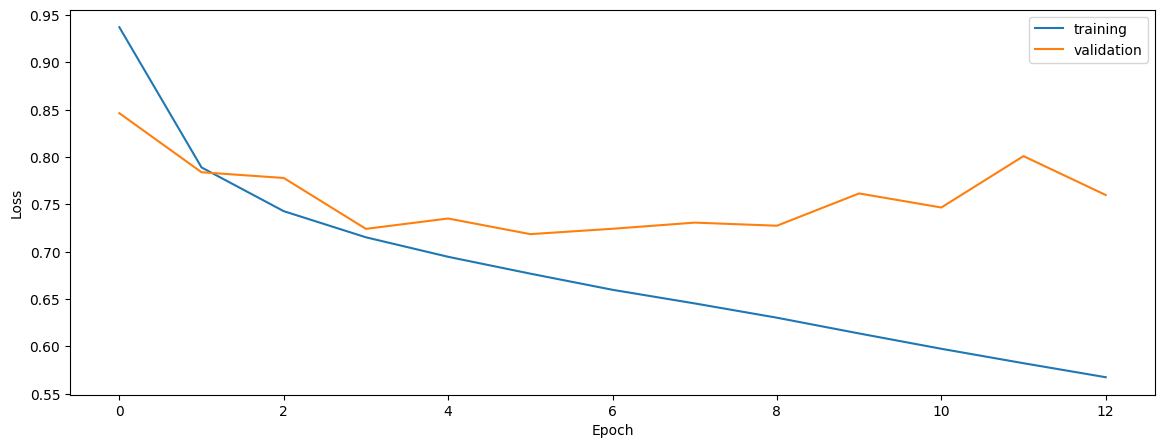

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


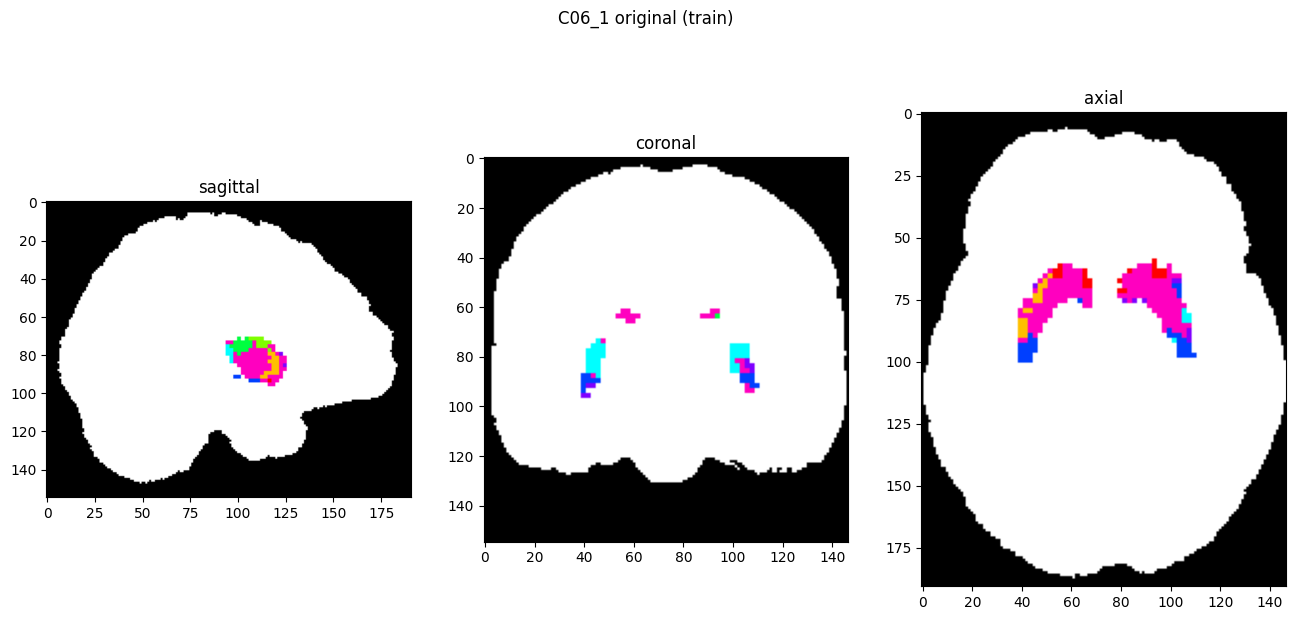

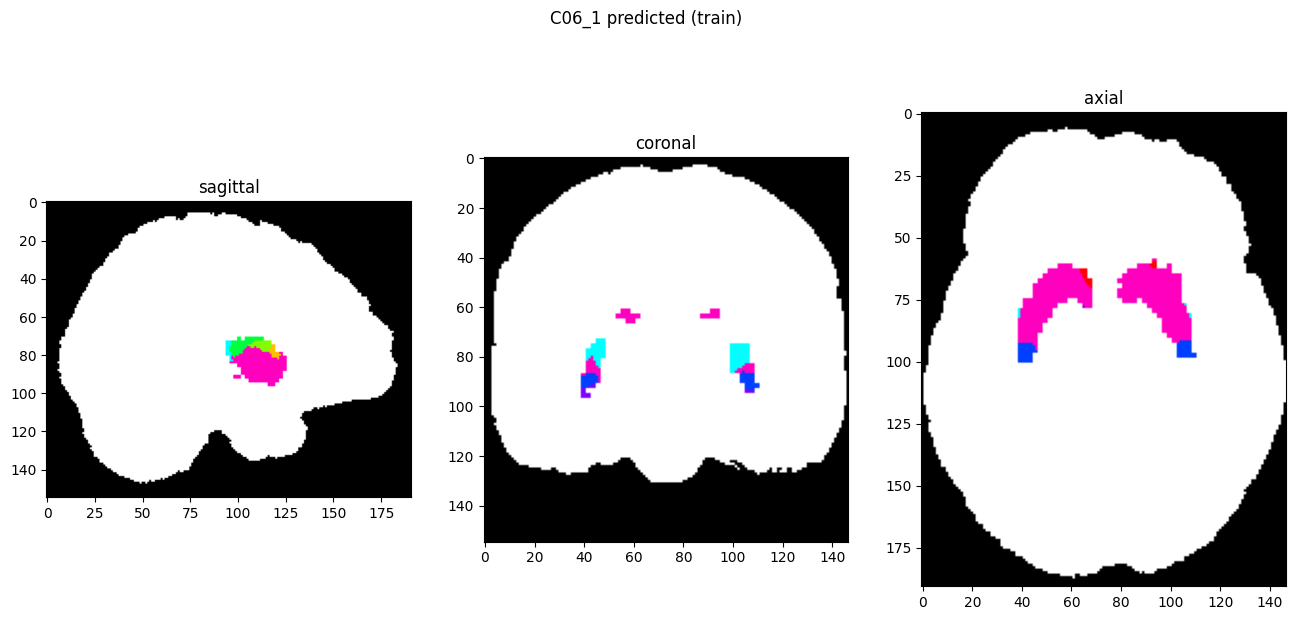

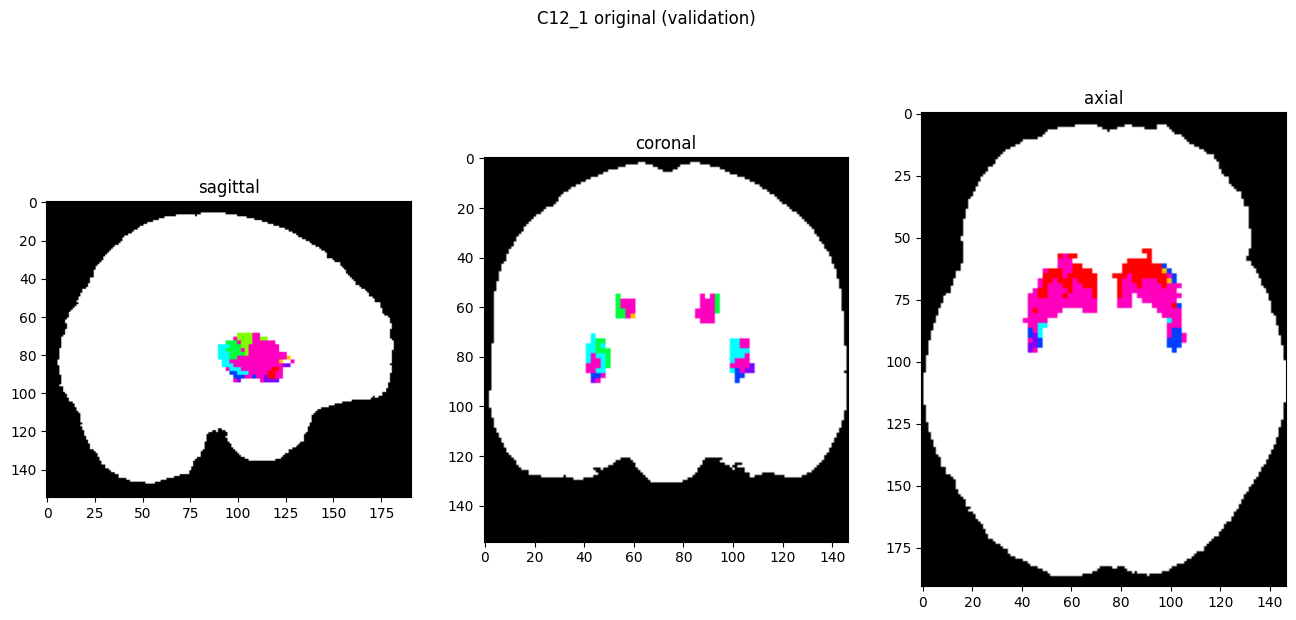

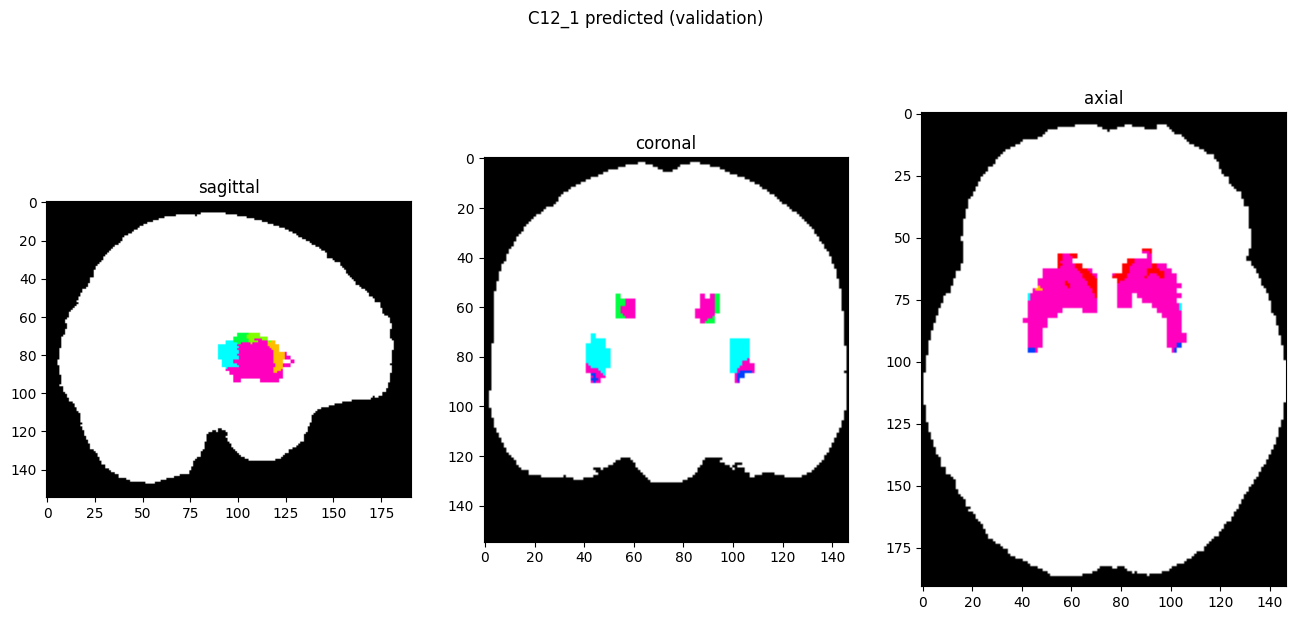

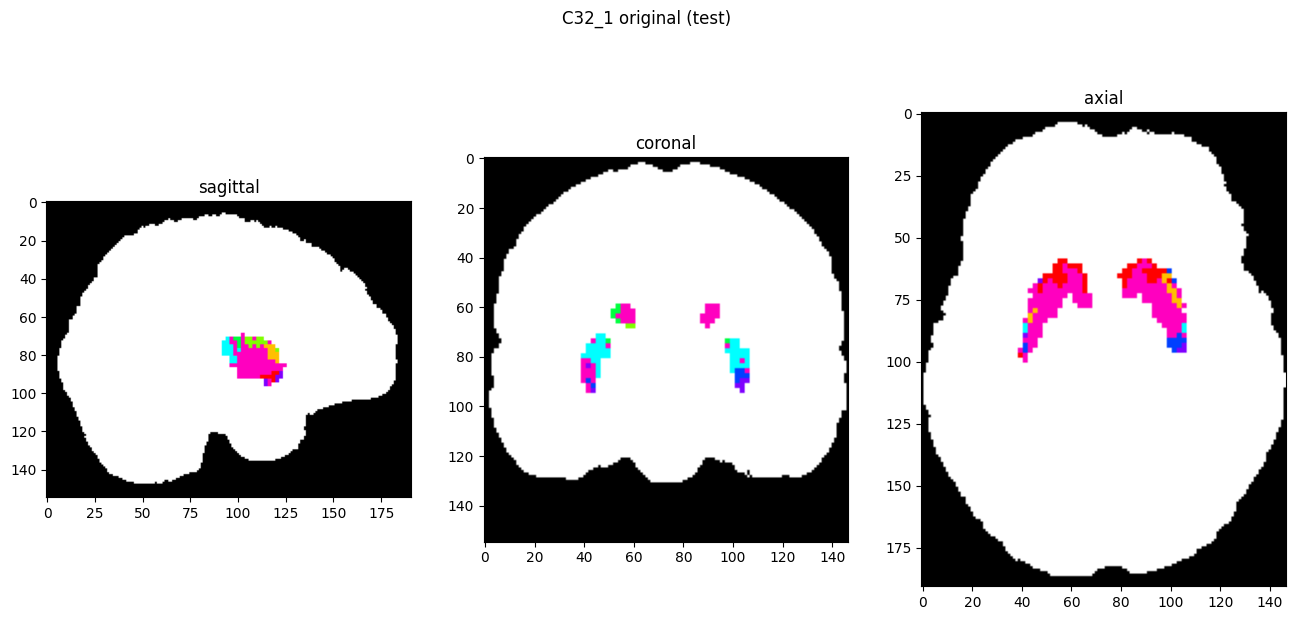

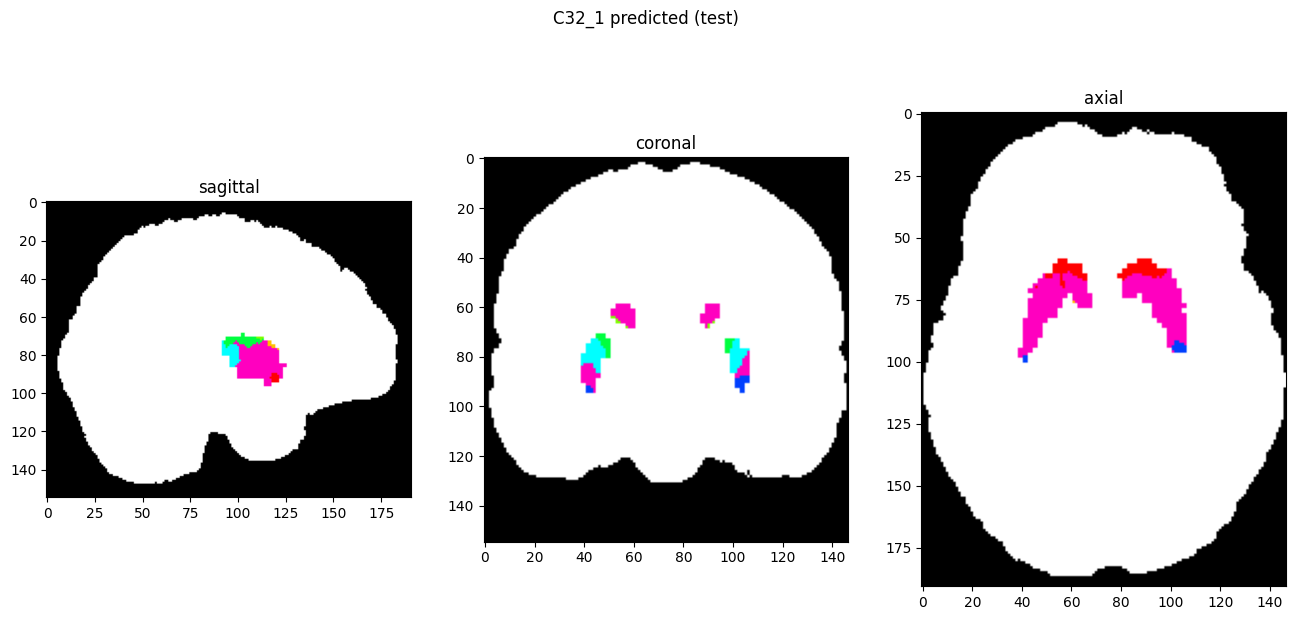

In [10]:
showResults(model, gen, threshold=0)